# Data Understanding

In [1]:
from os import walk
from functools import reduce
import pandas as pd
import dataframe_image as dfi
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, balanced_accuracy_score

## Import data

In [2]:
import os
import os.path

def merge_data_frames(data_frames):
    """Merge a data frame list into a single pd data frame.
    
    Parameters:
        data_frames (list of DataFrame): description.
    
    Return:
        pd DataFrame: the result.
    """
    data_frames = tuple(x for x in data_frames if 'SEQN' in x)
    merged_df = data_frames[0]
    for other_df in data_frames[1:]:
        #columns = tuple(x for x in other_df.columns if x not in merged_df.columns) + ("SEQN",)
        #other_df = other_df.filter(items=columns)
        merged_df = pd.merge(merged_df, other_df, on=['SEQN'], how='outer')

    return merged_df



def create_pd_data_frame_survey_component(dir_path, filter):
    """Create a pandas data frame from survey component files in a directory.
    
    Parameters:
        dir_path (str): Path to the directory containing the survey component files.
        filter (list): List of file prefixes to include. If None, include all files.
        
    Return:
        pd DataFrame: The merged data frame from the survey component files.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(dir_path):
        files.extend(filenames)
        break
        
    data_frames = []
    for file in files:
        if filter is not None and not any(file.startswith(x) for x in filter):
            continue

        file_path = os.path.join(dir_path, file)
        data_frame = pd.read_sas(file_path)
        data_frames.append(data_frame)

    if not data_frames:
        return None

    return merge_data_frames(data_frames)


def create_pd_data_frame_per_year(year_folder, filter=None):
    """Create a pandas data frame for a specific year folder.
    
    Parameters:
        year_folder (str): Name of the year folder.
        filter (list): List of file prefixes to include. If None, include all files.
        
    Return:
        pd DataFrame: The merged data frame for the specified year.
    """
    project_dir = os.getcwd()
    data_dir = os.path.join(project_dir, 'data', year_folder)
    folders = ['D', 'E', 'L', 'Q']

    data_frames = []
    for folder in folders:
        path = os.path.join(data_dir, folder)
        data_frame = create_pd_data_frame_survey_component(path, filter)
        if data_frame is not None:
            data_frames.append(data_frame)

    if not data_frames:
        return []

    big_data_per_year = merge_data_frames(data_frames)
    return big_data_per_year

In [3]:
# Create data frames for different years
data_2017_2018 = create_pd_data_frame_per_year('2017-2018')
data_2015_2016 = create_pd_data_frame_per_year('2015-2016')
data_2013_2014 = create_pd_data_frame_per_year('2013-2014')

In [4]:
# Merge dataset of different years
data_2013_2016 = data_2013_2014.append(data_2015_2016)
data_2013_to_2018 = data_2013_2016.append(data_2017_2018)

In [5]:
# Check duplicate rows, SEQN is instance ID
duplicateRows = data_2013_to_2018[data_2013_to_2018.duplicated(['SEQN'])]
duplicateRows

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,MCQ366B,MCQ366C,MCQ366D,MCQ371A,MCQ371B,MCQ371C,MCQ371D,OCQ670,SMQ690K,SMQ857O


## Data structure and NA values exploration

### Target column: MCQ160F

In [6]:
# Check NA values in target column MCQ160F
MCQ160F_NA = data_2013_to_2018[['SEQN', 'MCQ160F']].isnull().sum()

In [7]:
MCQ160F_NA

SEQN           0
MCQ160F    12343
dtype: int64

In [8]:
# Remove rows with NA values in target column MCQ160F
data_MCQ160F_no_NA = data_2013_to_2018[data_2013_to_2018['MCQ160F'].notna()]

In [9]:
data_MCQ160F_no_NA.shape

(17057, 606)

### Independent variables

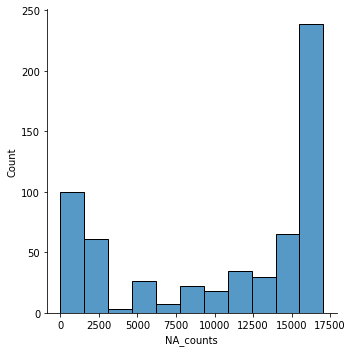

In [10]:
# Check NA values in independent variables
NA_columns = data_MCQ160F_no_NA.isnull().sum()
NA_columns = pd.DataFrame(NA_columns)
NA_columns = NA_columns.set_axis(['NA_counts'], axis=1)
sns.displot(data=NA_columns, x="NA_counts")
plt.show()

In [12]:
NA_column_list = []
for row_idx in range(len(NA_columns)):
    if NA_columns.iloc[row_idx,0] > len(data_MCQ160F_no_NA)*0.1: #drop columns that have more than 10% NA
        NA_column_list.append(NA_columns.index[row_idx])

In [13]:
data_MCQ160F_no_NA = data_MCQ160F_no_NA.drop(NA_column_list, axis=1)

In [14]:
# drop duplicate variables (those represent the same thing, just with different unit measurement in Laboratory dataset
# and big categorical demographic data
data_MCQ160F_no_NA = data_MCQ160F_no_NA.drop(['LBXTC', 'LBDSALSI', 'LBXSBU', 'LBDSCRSI', 'LBDSGBSI', 'LBXSGL', 'LBXSIR', 'LBXSPH', 'LBXSTB', 'LBXSCA',
                                             'LBXSCH', 'LBXSTP', 'LBXSTR', 'LBXSUA', #lab data
                                              'SDDSRVYR', 'RIDSTATR', 'RIDEXMON', 'SIALANG', 'SIAPROXY', 'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP',
                                              'DMDHRGND', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA' #demographic data
                                             ], axis=1)

In [15]:
data_MCQ160F_no_NA.shape

(17057, 116)

In [17]:
# change 8 to 9 as indication for NA in BPAARM col
data_MCQ160F_no_NA.loc[data_MCQ160F_no_NA['BPAARM'] == 8, ['BPAARM']] = 9

In [18]:
data_MCQ160F_clean_Q_code = data_MCQ160F_no_NA.copy()

In [19]:
# Get column max value to detect NA
column_max_value1 = pd.DataFrame(data_MCQ160F_clean_Q_code.max(), columns = ['max_value'])
pd.set_option("display.max_rows", 200)
column_max_value1

,max_value
SEQN,102956.0
RIAGENDR,2.0
RIDAGEYR,80.0
RIDRETH1,5.0
RIDRETH3,7.0
DMQMILIZ,9.0
DMDBORN4,99.0
DMDCITZN,9.0
DMDEDUC2,9.0
DMDMARTL,99.0


In [20]:
# categorical variables: 9, 99 and 999 indicate NA
idx_9 = column_max_value1.index[column_max_value1['max_value'] == 9]
idx_99 = column_max_value1.index[column_max_value1['max_value'] == 99]
idx_999 = column_max_value1.index[column_max_value1['max_value'] == 999]

# numerical variables: 9999 indicates NA
idx_9999 = column_max_value1.index[column_max_value1['max_value'] == 9999]

In [21]:
idx_9

Index(['DMQMILIZ', 'DMDCITZN', 'DMDEDUC2', 'BPAARM', 'BPQ020', 'BPQ080',
       'DIQ010', 'DIQ050', 'DLQ010', 'DLQ020', 'DLQ040', 'DLQ050', 'DLQ060',
       'DLQ080', 'INQ020', 'INQ012', 'INQ030', 'INQ060', 'INQ080', 'INQ090',
       'INQ132', 'INQ140', 'INQ150', 'INDFMMPC', 'MCQ010', 'MCQ053', 'MCQ080',
       'MCQ092', 'MCQ160A', 'MCQ160N', 'MCQ160B', 'MCQ160C', 'MCQ160D',
       'MCQ160E', 'MCQ160F', 'MCQ160G', 'MCQ160M', 'MCQ160K', 'MCQ160L',
       'MCQ160O', 'MCQ203', 'MCQ220', 'MCQ300A', 'MCQ300B', 'MCQ300C',
       'OCD150', 'OCD390G', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665',
       'PFQ049', 'PFQ051', 'PFQ054', 'PFQ057', 'SMQ020'],
      dtype='object')

In [22]:
idx_99

Index(['DMDBORN4', 'DMDMARTL', 'INDHHIN2', 'INDFMIN2', 'IND235'], dtype='object')

In [23]:
idx_999

Index(['SMD460'], dtype='object')

In [24]:
idx_9999

Index(['PAD680'], dtype='object')

In [25]:
# Replace specific values with NaN to indicate missing values
for column in idx_9:
    data_MCQ160F_clean_Q_code[column] = data_MCQ160F_clean_Q_code[column].replace([7, 9], np.nan)
    
for column in idx_99:
    data_MCQ160F_clean_Q_code[column] = data_MCQ160F_clean_Q_code[column].replace([77, 99], np.nan)
    
for column in idx_999:
    data_MCQ160F_clean_Q_code[column] = data_MCQ160F_clean_Q_code[column].replace([777, 999], np.nan)
    
for column in idx_9999:
    data_MCQ160F_clean_Q_code[column] = data_MCQ160F_clean_Q_code[column].replace([7777, 9999], np.nan)

In [26]:
# New column max value after replacing missing values
column_max_value2 = pd.DataFrame(data_MCQ160F_clean_Q_code.max(), columns = ['max_value'])
column_max_value2

,max_value
SEQN,102956.0
RIAGENDR,2.0
RIDAGEYR,80.0
RIDRETH1,5.0
RIDRETH3,7.0
DMQMILIZ,2.0
DMDBORN4,2.0
DMDCITZN,2.0
DMDEDUC2,5.0
DMDMARTL,6.0


In [27]:
data_MCQ160F_with_NA = data_MCQ160F_clean_Q_code.copy()

In [28]:
pd.set_option("min_rows", 4)
data_MCQ160F_with_NA.round(2)

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMQMILIZ,DMDBORN4,DMDCITZN,DMDEDUC2,DMDMARTL,...,PFQ051,PFQ054,PFQ057,PFQ090,SMD460,SMAQUEX,SMQ020,SMDUPCA,SMD100BR,SMAQUEX2
0,73557.0,1.0,69.0,4.0,4.0,1.0,1.0,1.0,3.0,4.0,...,2.0,2.0,2.0,2.0,1.0,2.0,1.0,b'',b'',1.0
1,73558.0,1.0,54.0,3.0,3.0,2.0,1.0,1.0,3.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,b'',b'',1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9251,102954.0,2.0,41.0,4.0,4.0,2.0,1.0,1.0,5.0,5.0,...,1.0,2.0,2.0,2.0,0.0,2.0,2.0,b'',b'',1.0
9253,102956.0,1.0,38.0,3.0,3.0,2.0,1.0,1.0,4.0,3.0,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,b'',b'',1.0


## Data preparation for Random Forest model

In [29]:
# Check columns with only one unique value
cols = list(data_MCQ160F_with_NA.columns.values)
for col in cols:
    unique_value_count = data_MCQ160F_with_NA[col].nunique()
    if unique_value_count == 1:
        print(col)

SMAQUEX
SMAQUEX2


In [30]:
data_MCQ160F_with_NA['SMD100BR'].nunique()

216

In [31]:
data_MCQ160F_with_NA['SMDUPCA'].nunique()

337

In [32]:
# Drop unnecessary columns
data_MCQ160F_with_NA = data_MCQ160F_with_NA.drop(['SEQN', 'SMAQUEX', 'SMAQUEX2', 'SMDUPCA', 'SMD100BR'], axis=1)

In [33]:
data_MCQ160F_with_NA.shape

(17057, 111)

### Columns order re-arranging

In [34]:
# Identify categorical variables
og_cols = list(data_MCQ160F_no_NA.columns.values)
categorical_variables = []
for col in og_cols:
    unique_value_count = data_MCQ160F_no_NA[col].nunique()
    column_max_value = data_MCQ160F_no_NA[col].max()
    if unique_value_count < 20 and column_max_value == 99:
        categorical_variables.append(col)
    elif unique_value_count < 20 and column_max_value == 999:
        categorical_variables.append(col)
        
len(categorical_variables)

6

In [35]:
# Identify yes/no variables
cols = list(data_MCQ160F_with_NA.columns.values)
cols.remove('MCQ160F')
cols.remove('RIDAGEYR')

yes_no_variables = []
for col in cols:
    unique_value_count = data_MCQ160F_with_NA[col].nunique()
    column_max_value = data_MCQ160F_with_NA[col].max()
    if col in categorical_variables:
        continue
    if unique_value_count == 2 and column_max_value == 2:
        yes_no_variables.append(col)
        
len(yes_no_variables)

57

In [36]:
# Identify additional categorical variables
categorical_variables_2 = []
for col in cols:
    if col in yes_no_variables or col in categorical_variables:
        continue
    unique_value_count = data_MCQ160F_with_NA[col].nunique()
    column_max_value = data_MCQ160F_with_NA[col].max()
    if unique_value_count <= 7 and column_max_value <= 7:
        categorical_variables_2.append(col)

categorical_variables_2.append('RIDAGEYR')
        
len(categorical_variables_2)

14

In [37]:
# Identify numerical variables
numerical_variables = []
for col in cols:
    if col in yes_no_variables or col in categorical_variables or col in categorical_variables_2:
        continue
    else:
        numerical_variables.append(col)

numerical_variables.append('MCQ160F')

len(numerical_variables)

34

In [38]:
# Re-arrange columns
rearranged_columns = []
col_lists = [yes_no_variables, categorical_variables, categorical_variables_2, numerical_variables]
for col_list in col_lists:
    for col in col_list:
        rearranged_columns.append(col)
        
# re-arrange columns
data_MCQ160F_with_NA = data_MCQ160F_with_NA[rearranged_columns]

In [39]:
data_MCQ160F_eda = data_MCQ160F_with_NA.copy()
data_MCQ160F_eda.to_csv('data_MCQ160F_eda.csv', index=False)

In [40]:
data_MCQ160F_eda.shape

(17057, 111)

In [41]:
# Check NA count in each column
data_MCQ160F_eda_NAsum = pd.DataFrame(data_MCQ160F_eda.isnull().sum())
data_MCQ160F_eda_NAsum = data_MCQ160F_eda_NAsum.set_axis(['NA count'], axis=1)
data_MCQ160F_eda_NAsum.sum()

NA count    76452
dtype: int64

### Data preprocessing

In [42]:
# Separate features and target
X = data_MCQ160F_eda.iloc[:, :-1].values
y = data_MCQ160F_eda.iloc[:, -1].values
# Impute missing values
imputer = IterativeImputer()
X = imputer.fit_transform(X)
# Encode categorical variables
ct = ColumnTransformer(transformers=[("encoder", OrdinalEncoder(), slice(0, 77))], remainder="passthrough")
X = np.array(ct.fit_transform(X))
# Encode target variable
le = LabelEncoder()
y = le.fit_transform(y)
# Scale numerical variables
sc = StandardScaler()
X[:, 77:] = sc.fit_transform(X[:, 77:])

c:\program files\python39\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [43]:
X.shape

(17057, 110)

In [44]:
# Train Random Forest classifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X, y)

RandomForestClassifier(criterion='entropy', random_state=0)

In [45]:
# Getting variable's names ready for feature importance table
features = data_MCQ160F_eda.drop(['MCQ160F'], axis=1)
features = features.columns.values

In [46]:
rforest_data_allX = pd.DataFrame(X)
rforest_data_allX = rforest_data_allX.set_axis(features, axis=1)
feature_importance = pd.DataFrame(rforest_data_allX.columns.values, columns = ['Feature'])
feature_importance['Feature importance'] = classifier.feature_importances_
feature_importance = feature_importance.sort_values(by='Feature importance', ascending=False)

In [47]:
feature_importance

,Feature,Feature importance
76,RIDAGEYR,0.036289
93,LBXSCR,0.025729
52,PFQ051,0.021839
90,LBDSCHSI,0.021120
74,OCD150,0.020318
108,LBDTCSI,0.020247
97,LBDSIRSI,0.018674
79,BPXSY2,0.018398
91,LBXSCK,0.018380
84,LBXSAPSI,0.018037


In [48]:
labels = pd.read_excel('labels.xlsx')
labels2 = labels.drop(['File', 'No NA at all', 'have >90% of data', 'Importance value', 'Chosen', 'VIF'], axis=1)

In [49]:
feature_importance = pd.merge(feature_importance, labels2, on='Feature')

In [50]:
feature_importance

,Feature,Feature importance,Labels,Importance rank
0,RIDAGEYR,0.036289,RIDAGEYR - Age in years at screening,1.0
1,LBXSCR,0.025729,"LBXSCR - Creatinine, refrigerated serum (mg/dL)",2.0
2,PFQ051,0.021839,PFQ051 - Limited in amount of work you can do,3.0
3,LBDSCHSI,0.021120,"LBDSCHSI - Cholesterol, refrigerated serum (mm...",4.0
4,OCD150,0.020318,OCD150 - Type of work done last week,5.0
5,LBDTCSI,0.020247,LBDTCSI - Total Cholesterol (mmol/L),6.0
6,LBDSIRSI,0.018674,"LBDSIRSI - Iron, refrigerated serum (umol/L)",7.0
7,BPXSY2,0.018398,BPXSY2 - Systolic: Blood pres (2nd rdg) mm Hg,8.0
8,LBXSCK,0.018380,LBXSCK - Creatine Phosphokinase (CPK) (IU/L),9.0
9,LBXSAPSI,0.018037,LBXSAPSI - Alkaline Phosphatase (ALP) (IU/L),10.0


In [51]:
dfi.export(feature_importance, 'feature_importance.png')